### 1. Introduction

In this assignment, the spectral modularity method will be used to find communities (groups) within the famous Karate Club network. The workflow includes:

- Import required libraries  
- Define a modularity-based community detection class (with spectral splitting)  
- Run the algorithm and visualize the detected communities  
- Compute several node centrality metrics

### 2. Import Required Libraries

We need numpy and networkx for matrix operations and graph manipulation, and matplotlib for visualization.

- numpy — numerical arrays and matrix operations  
- networkx — graph creation and analysis (Karate Club network)  
- matplotlib — plotting and visualization



In [7]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# In Jupyter, enable inline plotting
%matplotlib inline

### 3. Defining the Community Detector Class

This class will implement a modularity-based spectral community detection pipeline and provide utilities for labeling and analysis.

- Compute the modularity matrix for node subsets  
  - Build modularity matrix B = A - k k^T / (2m) for the current subgraph (A = adjacency, k = degree vector, m = total edges).  
  - Use B restricted to the node subset when splitting.

- Perform spectral splitting using the leading eigenvector  
  - Compute the principal eigenvector of B (power iteration / numpy.linalg.eig).  
  - Partition nodes by the sign of the corresponding eigenvector components.  
  - Evaluate modularity gain and only accept splits that increase modularity.

- Recursively divide the network to find communities  
  - Use a stack/queue to iteratively split groups that yield positive modularity gain.  
  - Stop when no further beneficial splits are possible or groups reach a minimum size.

- Assign and visualize community labels  
  - Map each node to a community id.  
  - Provide a plotting method that colors nodes by community (using networkx + matplotlib) and optionally displays modularity score.

- Compute centrality measures  
  - Provide methods to compute and return per-node metrics: degree, betweenness, closeness, and clustering coefficient (using networkx).  
  - Optionally attach these metrics to node attributes or export as a pandas DataFrame for inspection.

In [8]:
class CommunityDetector:
    def __init__(self, G):
        self.G = G
        self.n = G.number_of_nodes()
        self.A = nx.to_numpy_array(G, weight=None)
        self.degrees = np.sum(self.A, axis=1)
        self.m = int(np.sum(self.degrees) / 2)
        self.node_list = list(G.nodes())
        self.pos = nx.spring_layout(G, seed=42)
        self.communities = {}
        self.history = []

    def compute_modularity_matrix(self, nodes):
        idx = [self.node_list.index(n) for n in nodes]
        k_C = self.degrees[idx]
        A_C = self.A[np.ix_(idx, idx)]
        B_C = A_C - np.outer(k_C, k_C) / (2 * self.m)
        return B_C, k_C, idx

    def spectral_split(self, nodes):
        # Don't split empty or singleton set
        if len(nodes) < 2:
            # For 0 or 1 nodes, eigen decomposition is not meaningful
            return 0.0, nodes, [], np.array([])
        B_C, k_C, idx = self.compute_modularity_matrix(nodes)
        lambdas, vecs = np.linalg.eigh(B_C)
        idx_max = np.argmax(lambdas)
        lambda1 = lambdas[idx_max]
        u1 = vecs[:, idx_max]
        # Partition by sign
        group1 = [nodes[i] for i in range(len(nodes)) if u1[i] >= 0]
        group2 = [nodes[i] for i in range(len(nodes)) if u1[i] < 0]
        return lambda1, group1, group2, u1

    def detect_communities(self, verbose=True):
        queue = [list(self.G.nodes())]
        final_communities = []
        iteration = 0
        while queue:
            nodes = queue.pop(0)
            if len(nodes) < 2:
                # Community too small to split
                final_communities.append(nodes)
                continue
            lambda1, group1, group2, u1 = self.spectral_split(nodes)
            if verbose:
                print(f"Iteration {iteration}: community size = {len(nodes)}, lambda1 = {lambda1:.4f}")
            # Stop splitting if leading eigenvalue <= 0 or community is small
            if lambda1 <= 1e-10 or len(nodes) < 3 or min(len(group1), len(group2)) == 0:
                final_communities.append(nodes)
            else:
                queue.append(group1)
                queue.append(group2)
            iteration += 1
        self.communities = final_communities
        return final_communities


    def assign_clusters(self):
        labels = np.zeros(self.n, dtype=int)
        for cluster_idx, cluster in enumerate(self.communities):
            for node in cluster:
                labels[self.node_list.index(node)] = cluster_idx
        return labels

    def compute_metrics(self):
        centrality = {}
        centrality['degree'] = nx.degree_centrality(self.G)
        centrality['betweenness'] = nx.betweenness_centrality(self.G)
        centrality['closeness'] = nx.closeness_centrality(self.G)
        centrality['clustering'] = nx.clustering(self.G)
        return centrality

    def draw_communities(self):
        labels = self.assign_clusters()
        colors = plt.cm.tab10(labels / max(labels.max(), 1))
        nx.draw(self.G, pos=self.pos, node_color=colors, with_labels=True)
        plt.show()

### 4. Run Community Detection on the Karate Club Graph

Create the classic Karate Club network, run the spectral modularity detector, visualize the resulting communities, and inspect basic outputs (community membership and centrality metrics).

- Create the Karate Club graph using networkx  
- Instantiate the CommunityDetector with the graph  
- Run detect_communities() to find communities  
- Visualize communities with draw_communities()  
- Compute and print centrality measures



Iteration 0: community size = 34, lambda1 = 4.9771
Iteration 1: community size = 16, lambda1 = 2.9441
Iteration 2: community size = 18, lambda1 = 2.5041
Iteration 3: community size = 10, lambda1 = 2.5712
Iteration 4: community size = 6, lambda1 = 2.1480
Iteration 5: community size = 5, lambda1 = 1.8759
Iteration 6: community size = 13, lambda1 = 2.3563
Iteration 7: community size = 5, lambda1 = 2.1470

Found 5 communities:
 Community 1: [0, 1, 2, 3, 7, 12, 13, 17, 19, 21]
 Community 2: [24, 25, 27, 28, 31]
 Community 3: [8, 9, 14, 15, 18, 20, 22, 23, 26, 29, 30, 32, 33]
 Community 4: [11]
 Community 5: [4, 5, 6, 10, 16]


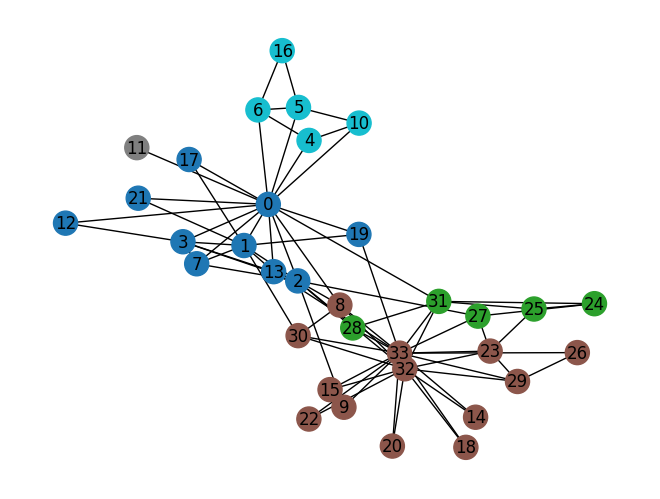

In [9]:
# Creating the graph and instantiating the detector
G = nx.karate_club_graph()
detector = CommunityDetector(G)

# Running the community detection algorithm
communities = detector.detect_communities(verbose=True)

print(f"\nFound {len(communities)} communities:")
for idx, comm in enumerate(communities):
    print(f" Community {idx+1}: {comm}")

# Assigning clusters and visualizing the result
labels = detector.assign_clusters()
detector.draw_communities()

### 5. Compute and Display Centrality Metrics

Compute degree, betweenness, closeness, and clustering coefficients for all nodes and display summary outputs.

- Use the detector's compute_metrics() method to get per-node measures.  
- Print or sort results to inspect top nodes by each metric.  
- Optionally convert to a pandas DataFrame for nicer display/export.



In [10]:
import pandas as pd

metrics = detector.compute_metrics()
node_ids = list(metrics['degree'].keys())
df_metrics = pd.DataFrame({
    'Node': node_ids,
    'Degree': [metrics['degree'][i] for i in node_ids],
    'Betweenness': [metrics['betweenness'][i] for i in node_ids],
    'Closeness': [metrics['closeness'][i] for i in node_ids],
    'Clustering': [metrics['clustering'][i] for i in node_ids],
})

# Display the full table nicely
df_metrics = df_metrics.set_index('Node')
display(df_metrics)

,Degree,Betweenness,Closeness,Clustering
Node,,,,
0,0.484848,0.437635,0.568966,0.150000
1,0.272727,0.053937,0.485294,0.333333
2,0.303030,0.143657,0.559322,0.244444
3,0.181818,0.011909,0.464789,0.666667
4,0.090909,0.000631,0.379310,0.666667
5,0.121212,0.029987,0.383721,0.500000
6,0.121212,0.029987,0.383721,0.500000
7,0.121212,0.000000,0.440000,1.000000
8,0.151515,0.055927,0.515625,0.500000
